# Speaker Recognition System

Dataset: 3 speakers 
Original clip count: 180 (60 clips each)

In [16]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [17]:
np.random.seed(42)

**Loading Data**

In [18]:
DATA_DIR = "../data/processed/"
SPEAKERS = ["anoushka", "ayushman", "saumi"]
SAMPLE_RATE = 16000 #downsampling all recordings to 16Khz due to differences in original samples. 

def load_audio_files():
    """Load all audio files and create dataset"""
    audio_data = []
    labels = []
    
    for speaker in SPEAKERS:
        speaker_path = os.path.join(DATA_DIR, speaker)
        files = [f for f in os.listdir(speaker_path) if f.endswith('.wav')]
        
        print(f"\nLoading {speaker}'s audio files...")
        for file in files:
            file_path = os.path.join(speaker_path, file)
            try:
                # Load audio
                audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                audio_data.append({'audio': audio, 'sr': sr, 'file': file})
                labels.append(speaker)
            except Exception as e:
                print(f"  Error loading {file}: {e}")
        
        print(f" Loaded {len(files)} files for {speaker}")
    
    return audio_data, labels

# Load dataset
audio_data, labels = load_audio_files()
print(f"\n Total audio clips loaded: {len(audio_data)}")
print(f"Distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")



Loading anoushka's audio files...
 Loaded 60 files for anoushka

Loading ayushman's audio files...
 Loaded 60 files for ayushman

Loading saumi's audio files...
 Loaded 60 files for saumi

 Total audio clips loaded: 180
Distribution: {np.str_('anoushka'): np.int64(60), np.str_('ayushman'): np.int64(60), np.str_('saumi'): np.int64(60)}



Visualizing sample waveforms...


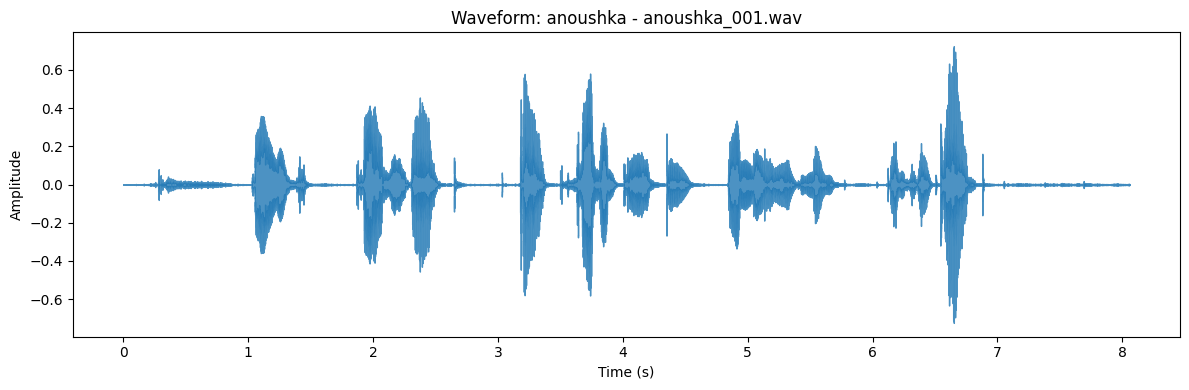

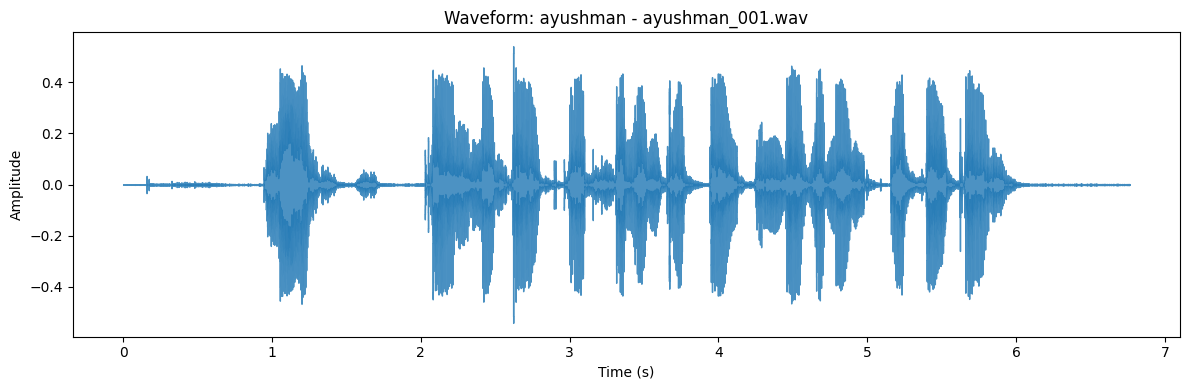

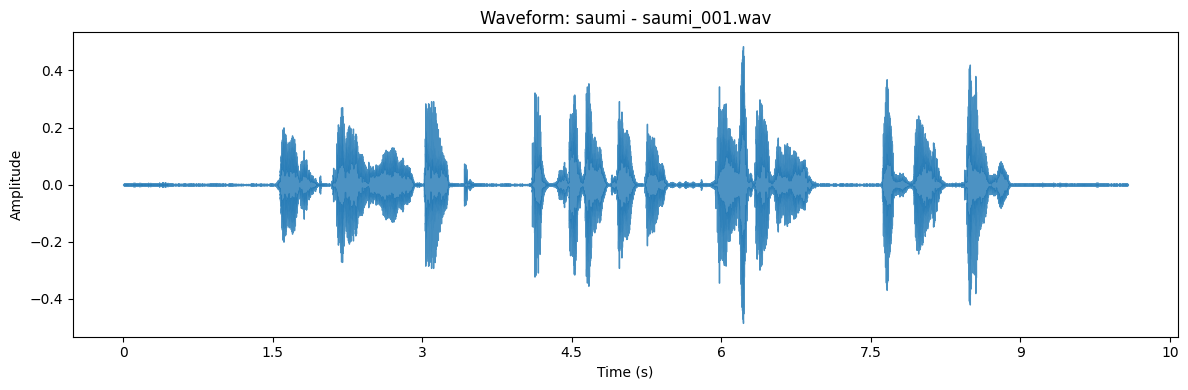

In [19]:
#visualizing the dataset
def plot_waveform(audio, sr, title):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr, alpha=0.8)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Taking one sample from each speaker
print("\nVisualizing sample waveforms...")
for i, speaker in enumerate(SPEAKERS):
    idx = labels.index(speaker)
    plot_waveform(audio_data[idx]['audio'], audio_data[idx]['sr'], 
                f"Waveform: {speaker} - {audio_data[idx]['file']}")

**Feature Extraction**

In [20]:
N_MFCC = 13          # Number of MFCC coefficients (standard)
N_FFT = 512         # FFT window size
HOP_LENGTH = 160     # Hop length for STFT

def extract_mfcc(audio, sr):
    """Extract MFCC features from audio"""
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, 
                                n_fft=N_FFT, hop_length=HOP_LENGTH)
    
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)
    
    features = np.concatenate([mfcc_mean, mfcc_std])
    
    return features

print("\nExtracting MFCC features...")
X = []  # Features
y = []  # Labels

for audio_dict, label in zip(audio_data, labels):
    features = extract_mfcc(audio_dict['audio'], audio_dict['sr'])
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"Feature extraction complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"(n_samples, n_features) = ({X.shape[0]} audio clips, {X.shape[1]} features per clip)")

# Saving extracted features
np.save('../data/features/X_features.npy', X)
np.save('../data/features/y_labels.npy', y)
print("Features saved to data/features/")


Extracting MFCC features...
Feature extraction complete!
Feature matrix shape: (180, 26)
(n_samples, n_features) = (180 audio clips, 26 features per clip)
Features saved to data/features/



MFCC Comparison (look for visual differences between speakers):


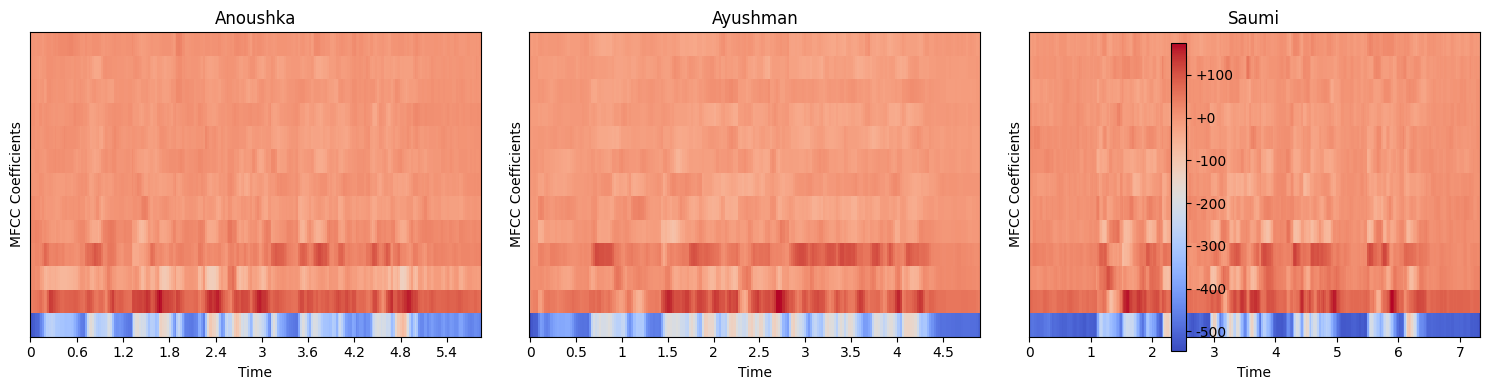

In [21]:
#visualizing extracted features
def plot_mfcc_comparison():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, speaker in enumerate(SPEAKERS):
        idx = np.where(y == speaker)[0][0]
        audio = audio_data[idx]['audio']
        sr = audio_data[idx]['sr']
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        img = librosa.display.specshow(mfccs, x_axis='time', ax=axes[i], cmap='coolwarm')
        axes[i].set_title(f'{speaker.capitalize()}')
        axes[i].set_ylabel('MFCC Coefficients')
        
    plt.colorbar(img, ax=axes, format='%+2.0f')
    plt.tight_layout()
    plt.show()

print("\nMFCC Comparison (look for visual differences between speakers):")
plot_mfcc_comparison()


**Training Model**

Since the original dataset is very small, audio clips are augmented with pitch shifts and time stretching

In [22]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
def augment_audio(audio, sr, num_augments=3):
    augmented = [audio]      
    for _ in range(num_augments):
        shift_amount = np.random.randint(-2, 3) 
        if shift_amount != 0:
            shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift_amount)
            augmented.append(shifted)
        
        stretch_factor = np.random.uniform(0.9, 1.1)  # 90% to 110% speed
        stretched = librosa.effects.time_stretch(audio, rate=stretch_factor)
        augmented.append(stretched)
    
    return augmented

print("\nCreating augmented training dataset...")
X_augmented = []
y_augmented = []

for audio_dict, label in zip(audio_data, labels):
    audio = audio_dict['audio']
    sr = audio_dict['sr']
    
    #original features
    original_features = extract_mfcc(audio, sr)
    X_augmented.append(original_features)
    y_augmented.append(label)
    
    #augmented versions
    augmented_audios = augment_audio(audio, sr, num_augments=2)
    for aug_audio in augmented_audios[1:]:  # Skip original
        aug_features = extract_mfcc(aug_audio, sr)
        X_augmented.append(aug_features)
        y_augmented.append(label)

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Augmented dataset created!")
print(f"Original samples: {X.shape[0]}")
print(f"Augmented samples: {X_augmented.shape[0]}")
print(f"Increase: {X_augmented.shape[0] / X.shape[0]:.1f}x")

# Re-encoding labels for augmented dataset
y_augmented_encoded = label_encoder.transform(y_augmented)

# Split augmented data
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_augmented, y_augmented_encoded, test_size=0.2, random_state=42, stratify=y_augmented_encoded
)

# Scaling augmented data
scaler_aug = StandardScaler()
X_train_aug_scaled = scaler_aug.fit_transform(X_train_aug)
X_test_aug_scaled = scaler_aug.transform(X_test_aug)

print(f"\nAugmented data split:")
print(f"  Training samples: {len(X_train_aug)}")
print(f"  Testing samples: {len(X_test_aug)}")



Creating augmented training dataset...
Augmented dataset created!
Original samples: 180
Augmented samples: 829
Increase: 4.6x

Augmented data split:
  Training samples: 663
  Testing samples: 166


In [23]:
def extract_mfcc_enhanced(audio, sr):
    """
    Extract enhanced MFCC features with deltas and normalization
    Includes:
    - MFCC coefficients
    - Delta (velocity) - captures rate of change
    - Delta-delta (acceleration) - captures change acceleration
    """
    # Normalize audio to prevent amplitude issues
    audio = audio / np.max(np.abs(audio))
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, 
                                n_fft=N_FFT, hop_length=HOP_LENGTH)
    
    # Compute deltas (first order derivative - rate of change)
    mfcc_delta = librosa.feature.delta(mfccs)
    
    # Compute delta-deltas (second order derivative - acceleration)
    mfcc_delta_delta = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate all features: mean and std for each feature type
    features = []
    
    # MFCC features
    features.append(np.mean(mfccs, axis=1))      # 13 features
    features.append(np.std(mfccs, axis=1))       # 13 features
    
    # Delta features
    features.append(np.mean(mfcc_delta, axis=1)) # 13 features
    features.append(np.std(mfcc_delta, axis=1))  # 13 features
    
    # Delta-delta features
    features.append(np.mean(mfcc_delta_delta, axis=1))  # 13 features
    features.append(np.std(mfcc_delta_delta, axis=1))   # 13 features
    
    # Combine all: 13 * 6 = 78 features total
    enhanced_features = np.concatenate(features)
    
    return enhanced_features

# Re-extract features with enhanced method for ALL data
print("\nRe-extracting features with enhanced MFCC (including deltas)...")
print(f"  Old feature dimension: 26")
print(f"  New feature dimension: 78 (MFCC + Deltas + Delta-deltas)")

X_enhanced = []
y_enhanced = []

for audio_dict, label in zip(audio_data, labels):
    features = extract_mfcc_enhanced(audio_dict['audio'], audio_dict['sr'])
    X_enhanced.append(features)
    y_enhanced.append(label)

X_enhanced = np.array(X_enhanced)
y_enhanced = np.array(y_enhanced)

print(f"Enhanced features extracted!")
print(f"Shape: {X_enhanced.shape}")

# Create augmented dataset with enhanced features
print(f"\nCreating augmented dataset with enhanced features...")
X_augmented_enhanced = []
y_augmented_enhanced = []

for audio_dict, label in zip(audio_data, labels):
    audio = audio_dict['audio']
    sr = audio_dict['sr']
    
    # Original features
    enhanced_features = extract_mfcc_enhanced(audio, sr)
    X_augmented_enhanced.append(enhanced_features)
    y_augmented_enhanced.append(label)
    
    # Augmented versions
    augmented_audios = augment_audio(audio, sr, num_augments=2)
    for aug_audio in augmented_audios[1:]:
        aug_features = extract_mfcc_enhanced(aug_audio, sr)
        X_augmented_enhanced.append(aug_features)
        y_augmented_enhanced.append(label)

X_augmented_enhanced = np.array(X_augmented_enhanced)
y_augmented_enhanced = np.array(y_augmented_enhanced)

print(f"Augmented enhanced dataset created!")
print(f"Samples: {X_augmented_enhanced.shape[0]}")
print(f"Features: {X_augmented_enhanced.shape[1]}")

# Encode and split
y_augmented_enhanced_encoded = label_encoder.transform(y_augmented_enhanced)

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_augmented_enhanced, y_augmented_enhanced_encoded, 
    test_size=0.2, random_state=42, stratify=y_augmented_enhanced_encoded
)

# Scale
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

print(f"\nEnhanced data split:")
print(f"Training: {len(X_train_enh)}")
print(f"Testing: {len(X_test_enh)}")



Re-extracting features with enhanced MFCC (including deltas)...
  Old feature dimension: 26
  New feature dimension: 78 (MFCC + Deltas + Delta-deltas)
Enhanced features extracted!
Shape: (180, 78)

Creating augmented dataset with enhanced features...
Augmented enhanced dataset created!
Samples: 825
Features: 78

Enhanced data split:
Training: 660
Testing: 165



 Updated model with enhanced features.
Final model trained

 Updated Model - Classification Report:
              precision    recall  f1-score   support

    anoushka       1.00      0.98      0.99        54
    ayushman       0.98      1.00      0.99        56
       saumi       1.00      1.00      1.00        55

    accuracy                           0.99       165
   macro avg       0.99      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165



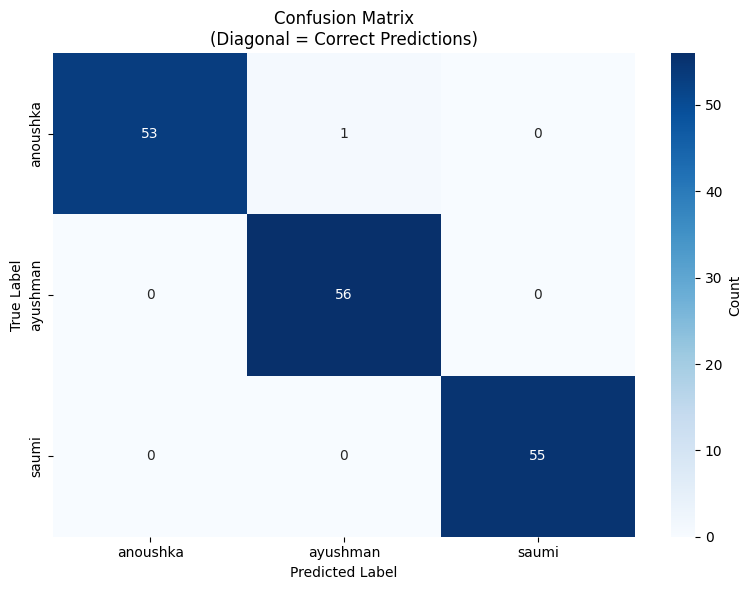


Per-speaker accuracy:
  anoushka: 53/54 correct (98.1%)
  ayushman: 56/56 correct (100.0%)
  saumi: 55/55 correct (100.0%)

Saving model...
Model saved to models/

Final confidence threshold: 0.9998

Saving final model...
Final model saved to models/


In [30]:
print("\n Updated model with enhanced features.")
svm_model_final = SVC(
    kernel='rbf', 
    C=10.0,
    gamma=0.01,
    probability=True, 
    random_state=42
)
svm_model_final.fit(X_train_enh_scaled, y_train_enh)
print("Final model trained")

# Evaluate
y_pred_final = svm_model_final.predict(X_test_enh_scaled)
accuracy_final = accuracy_score(y_test_enh, y_pred_final)

# print(f"\nMODEL ACCURACY COMPARISON:")
# print(f"  Original model:           {accuracy*100:.2f}%")
# print(f"  Augmented model:          {accuracy_improved*100:.2f}%")
# print(f"  Enhanced features model:  {accuracy_final*100:.2f}%")

# Detailed report
print(f"\n Updated Model - Classification Report:")
print(classification_report(y_test_enh, y_pred_final, target_names=label_encoder.classes_))



def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix\n(Diagonal = Correct Predictions)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print accuracy per speaker
    print("\nPer-speaker accuracy:")
    for i, speaker in enumerate(labels):
        correct = cm[i, i]
        total = cm[i].sum()
        acc = (correct / total) * 100
        print(f"  {speaker}: {correct}/{total} correct ({acc:.1f}%)")

plot_confusion_matrix(y_test_enh, y_pred_final, label_encoder.classes_)

# Save model and preprocessing objects
print("\nSaving model...")
with open('../models/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model_final, f)
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler_enh, f)
with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Model saved to models/")


# Update confidence threshold
y_train_proba_final = svm_model_final.predict_proba(X_train_enh_scaled)
train_confidence_final = np.max(y_train_proba_final, axis=1)
CONFIDENCE_THRESHOLD_FINAL = np.percentile(train_confidence_final, 90)

print(f"\nFinal confidence threshold: {CONFIDENCE_THRESHOLD_FINAL:.4f}")

svm_model = svm_model_final
scaler = scaler_enh
CONFIDENCE_THRESHOLD = CONFIDENCE_THRESHOLD_FINAL
extract_mfcc = extract_mfcc_enhanced  # enhanced extraction
print("\nSaving final model...")
with open('../models/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('../models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Final model saved to models/")


In [31]:
def test_clips_final(test_folder='../test_folder'):
    """Test final model with external audio clips"""
    if not os.path.exists(test_folder):
        print(f"Folder '{test_folder}' not found")
        return

    audio_files = [f for f in os.listdir(test_folder)
                   if f.endswith(('.wav', '.mp3', '.m4a'))]

    if not audio_files:
        print(f"No audio files found in '{test_folder}'")
        return

    print("="*70)
    print("FINAL SPEAKER RECOGNITION - IMPROVED MODEL TEST")
    print("="*70)

    results = []

    for filename in audio_files:
        file_path = os.path.join(test_folder, filename)

        try:
            # Load and analyze test audio
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            # Use enhanced feature extraction
            features = extract_mfcc_enhanced(audio, sr)
            features_scaled = scaler.transform([features])[0]
            
            # Get prediction and probabilities
            proba = svm_model.predict_proba([features_scaled])[0]
            confidence = np.max(proba)
            predicted_idx = np.argmax(proba)
            predicted_speaker = label_encoder.classes_[predicted_idx]
            
            # Always show the speaker with highest confidence
            status = "Confirmed" if confidence > 0.7 else "Low confidence"
            
            results.append({
                'file': filename,
                'predicted': predicted_speaker,
                'confidence': confidence,
                **{f'prob_{s}': proba[i] for i, s in enumerate(label_encoder.classes_)}
            })

            print(f"\n{status} File: {filename}")
            print(f"  Duration: {len(audio) / sr:.2f}s")
            print(f"  Predicted: {predicted_speaker}")
            print(f"  Confidence: {confidence:.4f}")
            print("  Probabilities:")
            for speaker, prob in zip(label_encoder.classes_, proba):
                bar = "█" * int(prob * 30)
                print(f"    {speaker:12s}: {prob:.4f} {bar}")

        except Exception as e:
            print(f"\n✗ File: {filename}")
            print(f"  Error: {e}")
            results.append({
                'file': filename,
                'predicted': 'ERROR',
                'confidence': 0.0
            })

    print("\n" + "="*70)

    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv('../testing_results.csv', index=False)
    print("Results saved to testing_results.csv")
    
    return results_df

# Run final test
print("\n")
results = test_clips_final('../test_folder')




FINAL SPEAKER RECOGNITION - IMPROVED MODEL TEST

Confirmed File: record_out (61).wav
  Duration: 10.44s
  Predicted: saumi
  Confidence: 0.9961
  Probabilities:
    anoushka    : 0.0020 
    ayushman    : 0.0020 
    saumi       : 0.9961 █████████████████████████████

Confirmed File: record_out (62).wav
  Duration: 10.86s
  Predicted: saumi
  Confidence: 0.9973
  Probabilities:
    anoushka    : 0.0008 
    ayushman    : 0.0019 
    saumi       : 0.9973 █████████████████████████████

Confirmed File: record_out (63).wav
  Duration: 9.96s
  Predicted: saumi
  Confidence: 0.9974
  Probabilities:
    anoushka    : 0.0018 
    ayushman    : 0.0008 
    saumi       : 0.9974 █████████████████████████████

Confirmed File: Test1.wav
  Duration: 9.82s
  Predicted: ayushman
  Confidence: 0.9847
  Probabilities:
    anoushka    : 0.0081 
    ayushman    : 0.9847 █████████████████████████████
    saumi       : 0.0071 

Low confidence File: test2.wav
  Duration: 10.34s
  Predicted: anoushka
  Conf